# Import Libraries

In [63]:
import pandas as pd
import numpy as np
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier

from sklearn.model_selection import RandomizedSearchCV, train_test_split, RepeatedStratifiedKFold

In [66]:
train_df = pd.read_csv('train.csv', index_col=['id'])

In [67]:
X = train_df.drop(['target'], axis=1)
y = train_df.target

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=43)

# EDA

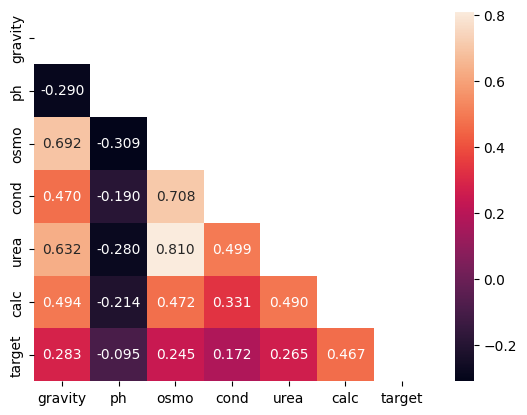

In [22]:
corr = train_df.corr()
mask = np.triu(corr)
sns_heat = sns.heatmap(corr, mask=mask,annot=True, fmt=".3f")

figure = sns_heat.get_figure()
figure.savefig('corr_heat.png', dpi=400)

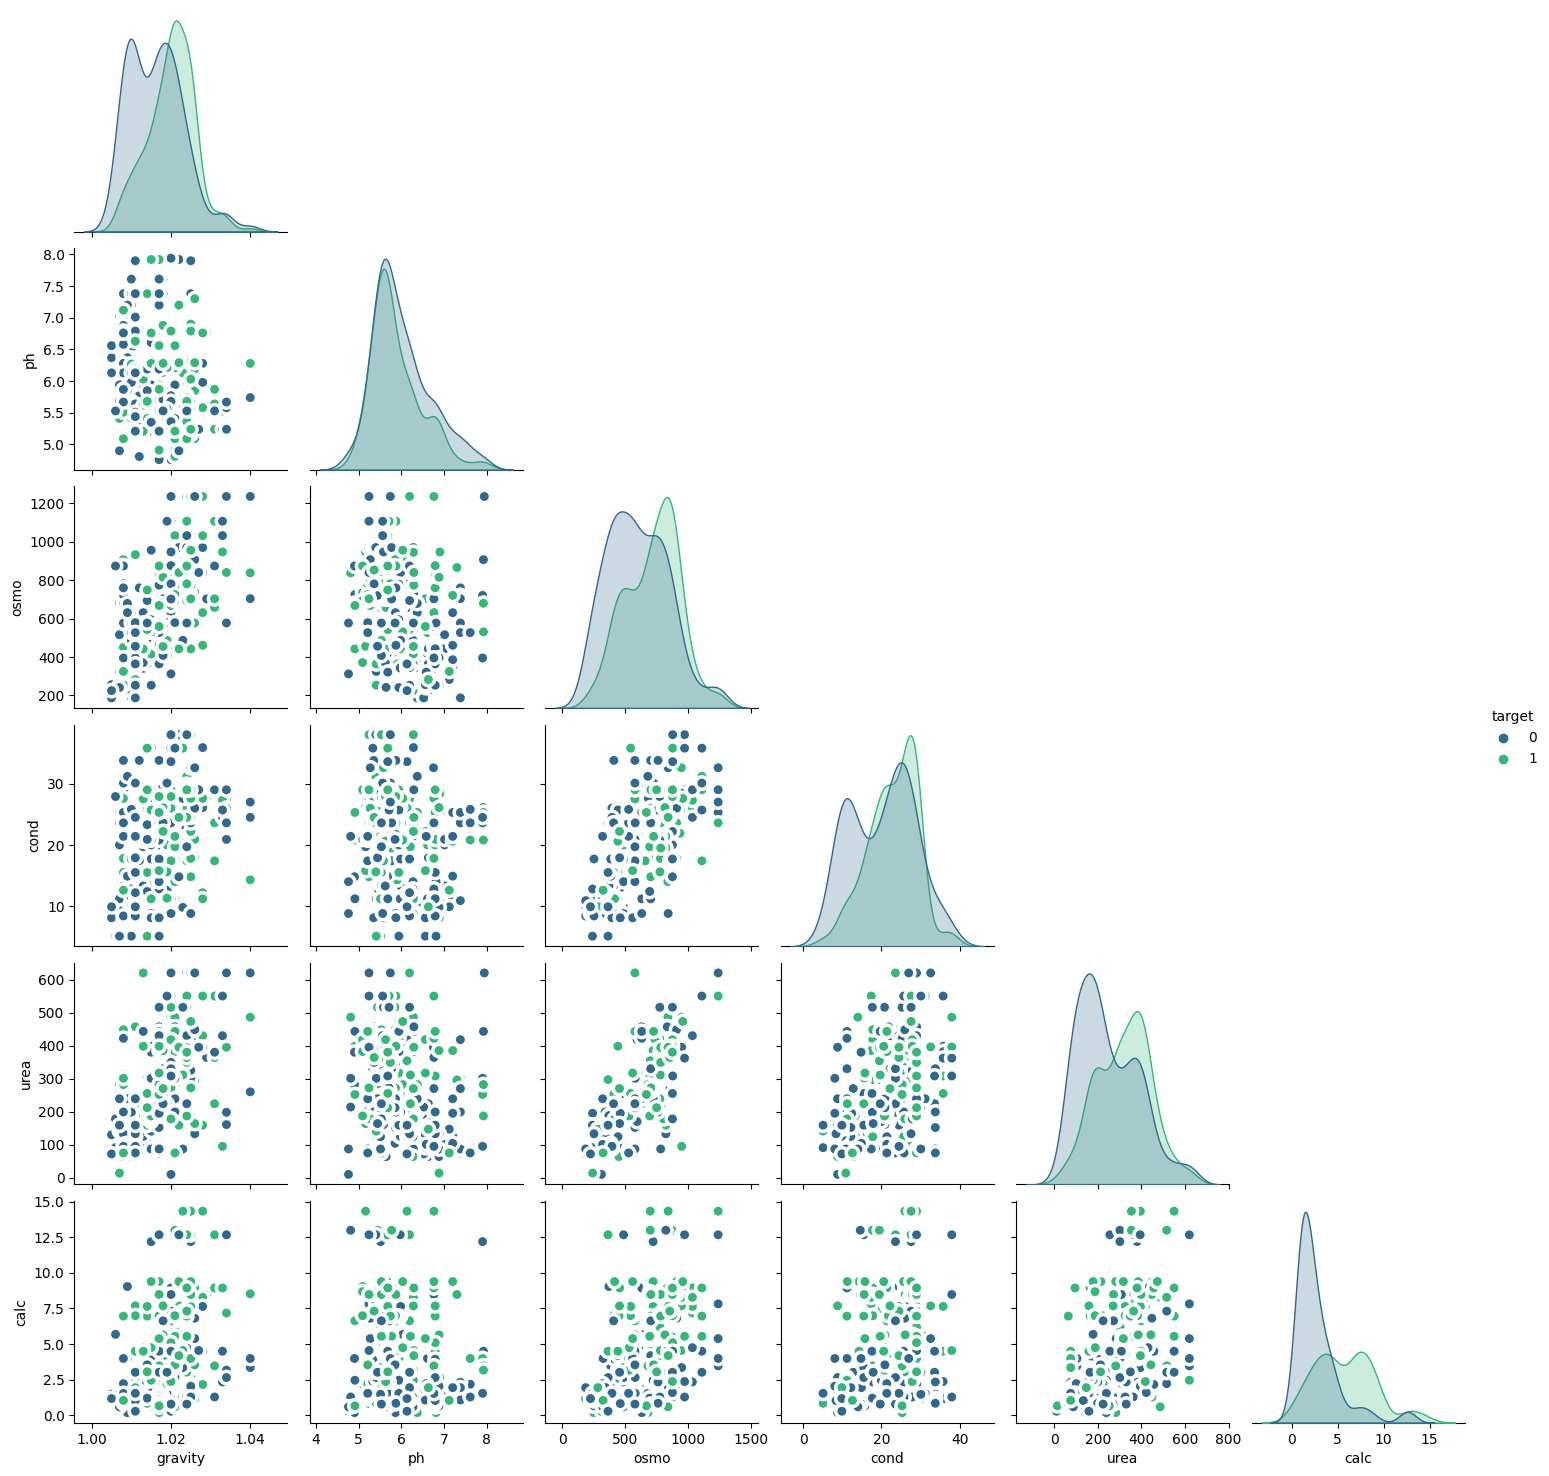

In [25]:
sns.pairplot(data=train_df, hue ='target', 
             corner=True, plot_kws={'s':80, 'edgecolor':"white", 'linewidth':2.5}, palette='viridis')


<h1><center> Modeling</center></h1>

In [6]:
# set verbosity to followed with info logging
optuna.logging.set_verbosity(optuna.logging.INFO)

def objective(trial):
    params={
        'verbosity': 0,
        'n_estimators': trial.suggest_int('n_estimators', 50, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 1e-7, 1e-1),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-5, 1e2),
        'lambda': trial.suggest_float('lambda', 1e-5, 1e2),
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'booster':trial.suggest_categorical("booster", ["dart", "gbtree",'gblinear']),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 5),
        'tree_method': 'gpu_hist'
    }
    
    kf = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=42)
    
    scores = []
    for train_idx, test_idx in kf.split(X,y):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[test_idx]
        
        
        xgb_model = XGBClassifier(**params)
        xgb_model.fit(X_train_fold, y_train_fold)
        
        y_pred = xgb_model.predict(X_val_fold)
        score = roc_auc_score(y_val_fold, y_pred)
        scores.append(score)
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, n_jobs=-1)

[I 2023-05-16 23:54:44,853] A new study created in memory with name: no-name-9cce0557-dc6a-49e6-aa1e-c5b747f451fd
[I 2023-05-16 23:55:59,516] Trial 4 finished with value: 0.5852021357742182 and parameters: {'n_estimators': 1118, 'learning_rate': 0.04775690099840665, 'max_depth': 15, 'colsample_bytree': 0.22184776074170054, 'alpha': 10.554650692113157, 'lambda': 58.29886340220971, 'booster': 'gblinear', 'min_child_weight': 0}. Best is trial 4 with value: 0.5852021357742182.
[I 2023-05-16 23:56:10,509] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 1316, 'learning_rate': 0.03575649820504398, 'max_depth': 19, 'colsample_bytree': 0.6087670691127444, 'alpha': 86.53417063194864, 'lambda': 99.0828429159025, 'booster': 'gblinear', 'min_child_weight': 4}. Best is trial 4 with value: 0.5852021357742182.
[I 2023-05-16 23:56:31,640] Trial 6 finished with value: 0.5 and parameters: {'n_estimators': 1284, 'learning_rate': 0.056087734238517, 'max_depth': 5, 'colsample_bytree': 0.70

In [65]:
study.best_params # optimized parameters

{'n_estimators': 521,
 'learning_rate': 0.048058528487311035,
 'max_depth': 19,
 'colsample_bytree': 0.45072121994519687,
 'alpha': 25.06956546276981,
 'lambda': 12.722971177461535,
 'booster': 'gbtree',
 'min_child_weight': 4}

In [53]:
xgb_optuna_params = {'n_estimators': 521,
 'learning_rate': 0.048058528487311035,
 'max_depth': 19,
 'colsample_bytree': 0.45072121994519687,
 'alpha': 25.06956546276981,
 'lambda': 12.722971177461535,
 'booster': 'gbtree',
 'min_child_weight': 4}

# Default Parameter

In [69]:
kf = RepeatedStratifiedKFold(n_splits = 10, random_state = 42, n_repeats = 10)

default_param_scores = []

for train_idx, val_idx in kf.split(X, y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    model = XGBClassifier().fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_val)
    
    score = roc_auc_score(y_val, y_pred[:, 1])
    default_param_scores.append(score)
    
print(np.array(default_param_scores).mean())

0.7515179252479025


# Optimized Parameter

In [70]:
kf = RepeatedStratifiedKFold(n_splits = 10, random_state = 42, n_repeats = 10)

optimize_param_score = []

for train_idx, val_idx in kf.split(X, y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    model = XGBClassifier(**xgb_optuna_params).fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_val)
    
    score = roc_auc_score(y_val, y_pred[:, 1])
    optimize_param_score.append(score)
    
print(np.array(optimize_param_score).mean())

0.7793122298499874
